# Interactive Plots with IPython Widgets

This notebook demonstrates how to use iSLAT's **class-based plotting module** together with **ipywidgets** to create interactive, GUI-like exploration tools directly inside a Jupyter notebook.

## What This Notebook Covers:
1. **Setup** — Imports, molecule creation, and observed data loading
2. **Interactive Line Inspection** — Slider-controlled wavelength zoom with `LineInspectionPlot`
3. **Interactive Molecule Parameters** — Adjust temperature, column density, and radius in real time
4. **Molecule Selector** — Dropdown to switch the active molecule in a `PopulationDiagramPlot`
5. **Full Interactive Dashboard** — A multi-panel `MainPlotGrid` with coordinated widget controls
6. **Visibility Toggles** — Checkboxes to show/hide individual molecules
7. **Custom Widget Layout** — Building a polished control panel with linked widgets

These examples combine the convenience of ipywidgets with the publication-quality output of matplotlib, giving you the interactivity of the iSLAT GUI in a notebook environment.

In [12]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent.parent  # Interactive Widgets -> Notebooks -> Examples -> iSLAT
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use the interactive widget backend for matplotlib
%matplotlib widget

# IPython widget libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# iSLAT standalone plot classes
from iSLAT.Modules.Plotting import (
    BasePlot,
    DEFAULT_THEME,
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
)

print("Imports successful!")
print(f"matplotlib backend: {matplotlib.get_backend()}")

Imports successful!
matplotlib backend: widget


In [13]:
# --- Load observed data and create molecules ---
import pandas as pd

# Load CI Tau MIRI spectrum (Banzatti+2023b)
data_path = Path(islat_root) / "iSLAT" / "DATAFILES" / "EXAMPLE-data" / "CITau_MIRI_Banzatti+2023b.csv"
obs = pd.read_csv(data_path)

wave_grid     = obs["wave"].values
observed_flux = obs["flux"].values
observed_err  = obs["err"].values
continuum     = obs["cont"].values

print(f"Loaded: {data_path.name}")
print(f"  {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

# Paths to HITRAN parameter files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"
water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

# Build a MoleculeDict with three molecules
wavelength_range = (float(wave_grid.min()), float(wave_grid.max()))

mol_dict = MoleculeDict(
    global_distance=160,
    global_stellar_rv=0.0,
    global_wavelength_range=wavelength_range,
    global_model_pixel_res=0.0013,
)

molecules_to_create = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "radius": 0.5, "color": "#0000FF",
             "displaylabel": "$H_2O$", "File Path": water_par_file},
    "CO":  {"Molecule Name": "CO",  "temp": 1000, "n_mol": 1e18, "radius": 0.4, "color": "#FF0000",
             "displaylabel": "CO",  "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 300,  "n_mol": 1e17, "radius": 0.5, "color": "green",
             "displaylabel": "$CO_2$", "File Path": co2_par_file},
}

mol_dict.load_molecules(
    molecules_data=[v for v in molecules_to_create.values()],
    initial_molecule_parameters=molecules_to_create,
)

# Set consistent FWHM and broadening
mol_dict.bulk_update_parameters({"fwhm": 130, "broad": 1})

print(f"MoleculeDict: {list(mol_dict.keys())}")
print(f"Observed data: {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

Loaded: CITau_MIRI_Banzatti+2023b.csv
  10672 points, 4.90–28.72 μm
Deferring intensity calculations for 3 molecules
MoleculeDict: ['H2O', 'CO', 'CO2']
Observed data: 10672 points, 4.90–28.72 μm


## 1. Interactive Line Inspection — Wavelength Range Slider

The simplest interactive pattern: use a `FloatRangeSlider` to control the wavelength bounds of a `LineInspectionPlot`. The plot updates in-place using `set_range()`, so there is no flicker or figure recreation.

**Key idea:** The `%matplotlib widget` backend keeps the figure canvas alive. We update the plot data and call `fig.canvas.draw_idle()` to refresh.

Calculating intensity for CO: T=1000.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=300.0K, N_mol=1.00e+17, dv=1.0


FloatRangeSlider(value=(14.0, 15.0), continuous_update=False, description='λ range (μm):', layout=Layout(width…

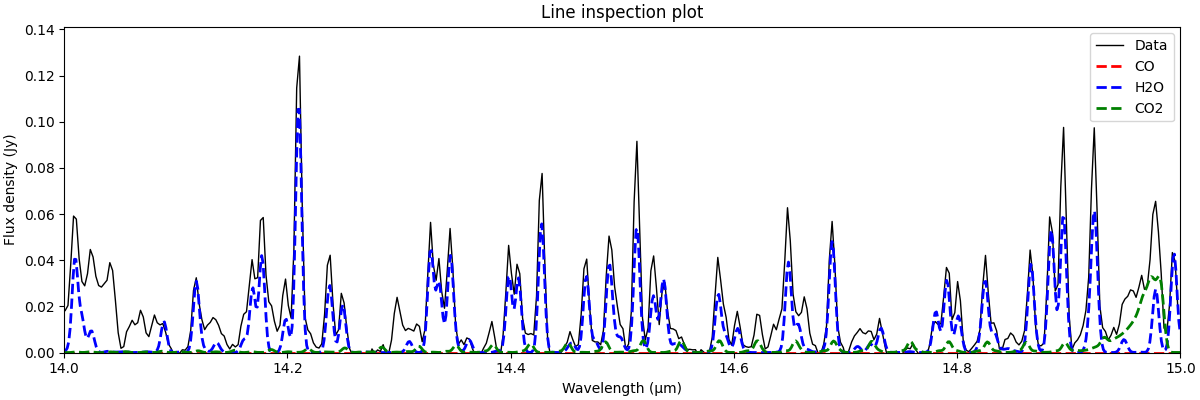

In [14]:
# --- Interactive wavelength range slider for LineInspectionPlot ---

# Create the initial plot
lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=15.0,
    molecules=mol_dict,
    figsize=(12, 4),
)
lip.generate_plot()

# Create a range slider
wave_min, wave_max = float(wave_grid.min()), float(wave_grid.max())

range_slider = widgets.FloatRangeSlider(
    value=[14.0, 15.0],
    min=wave_min,
    max=wave_max,
    step=0.1,
    description='λ range (μm):',
    continuous_update=False,        # only update on mouse release
    style={'description_width': '100px'},
    layout=widgets.Layout(width='600px'),
)

def on_range_change(change):
    """Update the plot when the slider moves."""
    xmin, xmax = change['new']
    lip.set_range(xmin, xmax)       # regenerates plot data in-place
    lip.fig.canvas.draw_idle()       # refresh the widget backend canvas

range_slider.observe(on_range_change, names='value')

# Display slider above the (already shown) figure
display(range_slider)
lip.show()

## 2. Interactive Molecule Parameters — Temperature, Column Density, Radius

Here we attach sliders for the key physical parameters of a single molecule. When a slider changes, we update the `Molecule` object directly — its internal caching automatically triggers the necessary recalculations — then refresh the plot.

This is the notebook equivalent of the iSLAT GUI parameter panel.

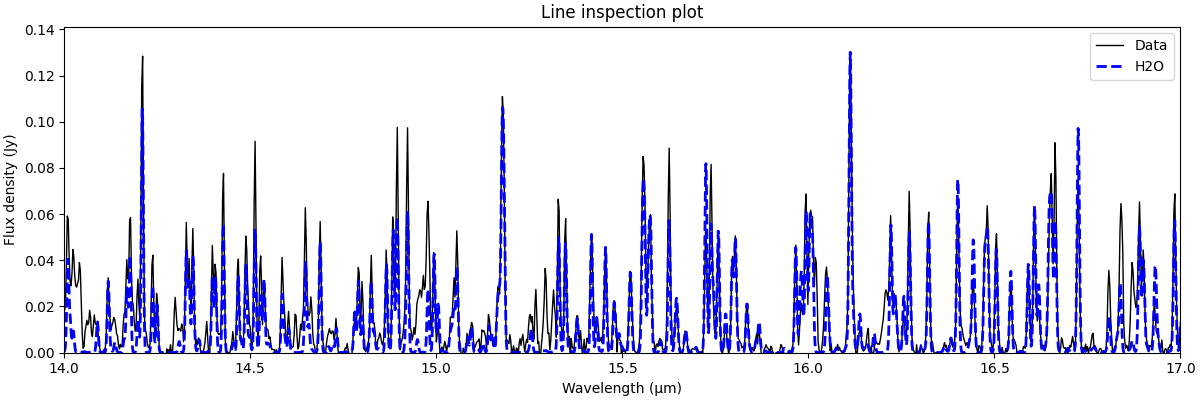

In [15]:
# --- Interactive parameter sliders for a single molecule (H2O) ---

mol = mol_dict["H2O"]

# Create the plot showing the H2O model in a narrow window
param_lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=17.0,
    molecule=mol,
    figsize=(12, 4),
)
param_lip.generate_plot()

# --- Build parameter sliders ---
temp_slider = widgets.IntSlider(
    value=int(mol.temp), min=100, max=2000, step=50,
    description='T (K):', continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

# Column density uses a log scale: slider value is the exponent
import math
log_n_init = math.log10(mol.n_mol)
log_n_slider = widgets.FloatSlider(
    value=log_n_init, min=14, max=22, step=0.1,
    description='log₁₀ N (cm⁻²):', continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
    readout_format='.1f',
)

radius_slider = widgets.FloatSlider(
    value=mol.radius, min=0.05, max=5.0, step=0.05,
    description='Radius (AU):', continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

# Label showing current parameter values
info_label = widgets.HTML(
    value=f"<b>{mol.displaylabel}</b> — T={mol.temp:.0f} K, "
          f"N={mol.n_mol:.1e} cm⁻², R={mol.radius:.2f} AU"
)

def update_molecule_params(change):
    """Update the molecule and regenerate the plot."""
    mol.temp = float(temp_slider.value)
    mol.n_mol = 10 ** log_n_slider.value
    mol.radius = radius_slider.value

    # Update info label
    info_label.value = (
        f"<b>{mol.displaylabel}</b> — T={mol.temp:.0f} K, "
        f"N={mol.n_mol:.1e} cm⁻², R={mol.radius:.2f} AU"
    )

    # Regenerate and redraw
    param_lip.generate_plot()
    param_lip.fig.canvas.draw_idle()

temp_slider.observe(update_molecule_params, names='value')
log_n_slider.observe(update_molecule_params, names='value')
radius_slider.observe(update_molecule_params, names='value')

# Layout: sliders stacked vertically, then the plot
controls = widgets.VBox([info_label, temp_slider, log_n_slider, radius_slider])
display(controls)
param_lip.show()

## 3. Molecule Selector — Dropdown for Population Diagrams

A `Dropdown` widget lets you switch the active molecule in a `PopulationDiagramPlot`. The plot class's `set_molecule()` method handles clearing and redrawing automatically.

Dropdown(description='Molecule:', options=('H2O', 'CO', 'CO2'), style=DescriptionStyle(description_width='80px…

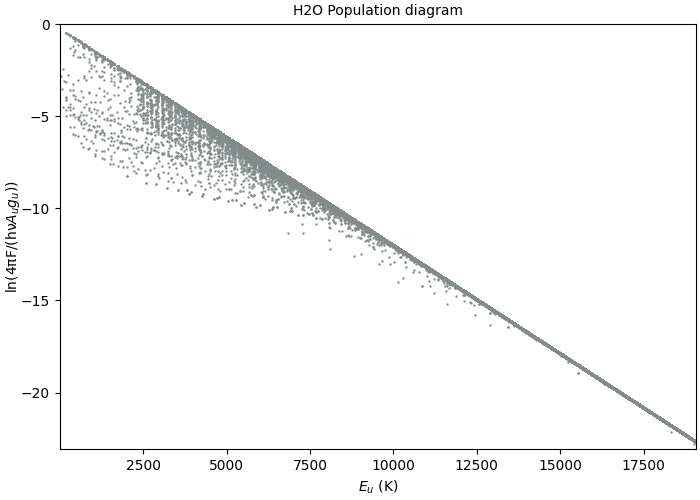

In [16]:
# --- Dropdown molecule selector for PopulationDiagramPlot ---

pdp = PopulationDiagramPlot(
    molecule=mol_dict["H2O"],
    figsize=(7, 5),
)
pdp.generate_plot()

# Build dropdown options: display label -> molecule key
mol_dropdown = widgets.Dropdown(
    options=list(mol_dict.keys()),
    value="H2O",
    description='Molecule:',
    style={'description_width': '80px'},
)

def on_molecule_change(change):
    """Switch the molecule shown in the population diagram."""
    mol_name = change['new']
    pdp.set_molecule(mol_dict[mol_name])
    pdp.fig.canvas.draw_idle()

mol_dropdown.observe(on_molecule_change, names='value')

display(mol_dropdown)
pdp.show()

## 4. Visibility Toggles — Checkboxes for Each Molecule

Use `Checkbox` widgets to toggle molecule visibility in a `LineInspectionPlot` that shows all visible molecules. This mirrors the molecule list panel in the iSLAT GUI.

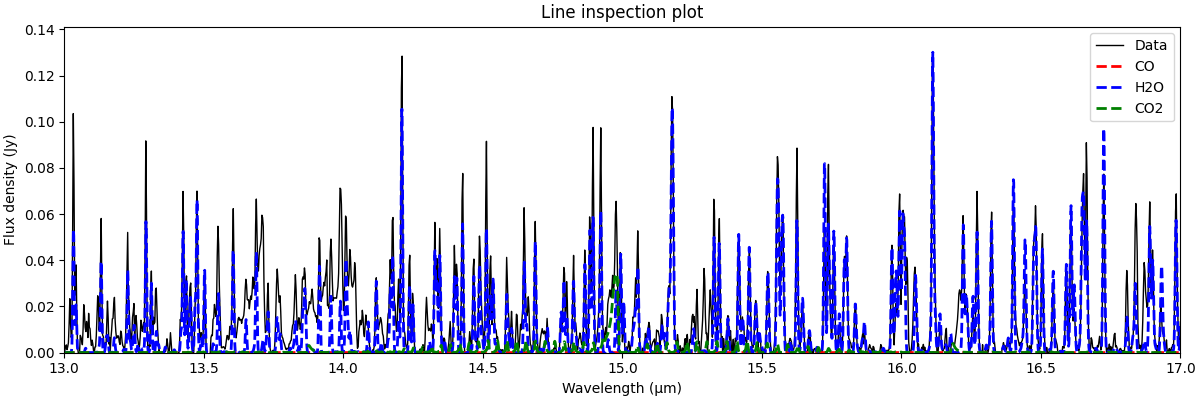

In [17]:
# --- Checkbox visibility toggles for molecules ---

vis_lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=13.0,
    xmax=17.0,
    molecules=mol_dict,
    figsize=(12, 4),
)
vis_lip.generate_plot()

# Create one checkbox per molecule, coloured to match
checkboxes = {}
for mol_name, mol in mol_dict.items():
    cb = widgets.Checkbox(
        value=mol.is_visible,
        description=mol_name,
        indent=False,
        layout=widgets.Layout(width='120px'),
    )
    checkboxes[mol_name] = cb

def on_visibility_change(change):
    """Toggle molecule visibility and refresh the plot."""
    # Sync checkbox states to molecule objects
    for mol_name, cb in checkboxes.items():
        mol_dict[mol_name].is_visible = cb.value

    vis_lip.generate_plot()
    vis_lip.fig.canvas.draw_idle()

# Attach observer to each checkbox
for cb in checkboxes.values():
    cb.observe(on_visibility_change, names='value')

# Arrange checkboxes in a horizontal row
checkbox_row = widgets.HBox(list(checkboxes.values()))
display(checkbox_row)
vis_lip.show()

## 5. Full Interactive Dashboard — MainPlotGrid with Coordinated Controls

This section combines multiple widget types into a single dashboard that drives a `MainPlotGrid` (the three-panel composite that mirrors the iSLAT GUI layout):

- **Molecule dropdown** — selects the active molecule for the inspection and population panels
- **Range slider** — controls the line inspection wavelength window
- **Parameter sliders** — adjust T, N, and R for the selected molecule in real time

All controls are coordinated: changing the active molecule updates the parameter sliders to reflect that molecule's current values.

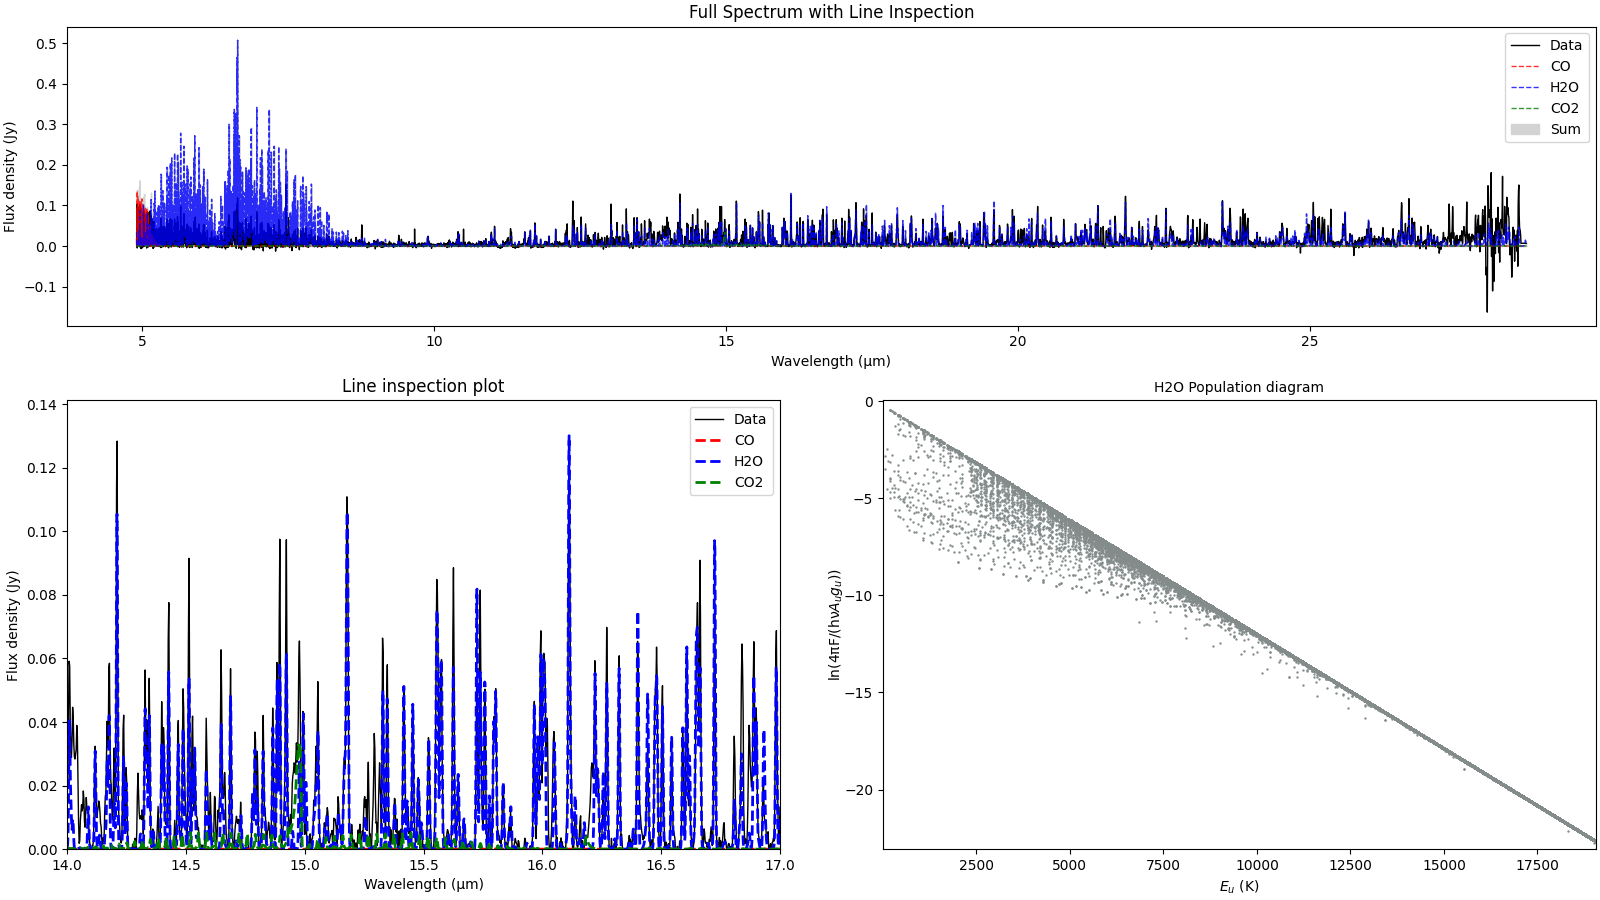

In [18]:
# --- Full interactive dashboard with MainPlotGrid ---

import math

# Create the three-panel grid
grid = MainPlotGrid(
    wave_data=wave_grid,
    flux_data=observed_flux,
    molecules=mol_dict,
    active_molecule=mol_dict["H2O"],
    inspection_range=(14.0, 17.0),
    figsize=(16, 9),
)
grid.generate_plot()

# ── Widgets ──────────────────────────────────────────────────────────────

# Molecule selector
dash_mol_dropdown = widgets.Dropdown(
    options=list(mol_dict.keys()),
    value="H2O",
    description='Active molecule:',
    style={'description_width': '120px'},
)

# Inspection wavelength range
dash_range_slider = widgets.FloatRangeSlider(
    value=[14.0, 17.0],
    min=float(wave_grid.min()),
    max=float(wave_grid.max()),
    step=0.1,
    description='Inspect λ (μm):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='600px'),
)

# Temperature slider
dash_temp_slider = widgets.IntSlider(
    value=int(mol_dict["H2O"].temp), min=100, max=2000, step=50,
    description='T (K):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
)

# log₁₀ column density
dash_logn_slider = widgets.FloatSlider(
    value=math.log10(mol_dict["H2O"].n_mol), min=14, max=22, step=0.1,
    description='log₁₀ N (cm⁻²):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
    readout_format='.1f',
)

# Emitting radius
dash_radius_slider = widgets.FloatSlider(
    value=mol_dict["H2O"].radius, min=0.05, max=5.0, step=0.05,
    description='Radius (AU):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='450px'),
)

# Status label
dash_status = widgets.HTML(value="<i>Ready</i>")

# ── Callbacks ────────────────────────────────────────────────────────────

_updating_sliders = False  # guard to prevent feedback loops

def sync_sliders_to_molecule(mol):
    """Set slider values to reflect the current molecule's parameters."""
    global _updating_sliders
    _updating_sliders = True
    dash_temp_slider.value = int(mol.temp)
    dash_logn_slider.value = round(math.log10(mol.n_mol), 1) if mol.n_mol > 0 else 14.0
    dash_radius_slider.value = mol.radius
    _updating_sliders = False

def on_dash_mol_change(change):
    """Switch active molecule and update slider positions."""
    mol_name = change['new']
    mol = mol_dict[mol_name]
    sync_sliders_to_molecule(mol)
    grid.set_active_molecule(mol)
    grid.fig.canvas.draw_idle()
    dash_status.value = f"<i>Active: {mol_name}</i>"

def on_dash_range_change(change):
    """Update inspection range in the grid."""
    xmin, xmax = change['new']
    grid.set_inspection_range(xmin, xmax)
    grid.fig.canvas.draw_idle()

def on_dash_param_change(change):
    """Update the active molecule's parameters and refresh all panels."""
    if _updating_sliders:
        return
    mol_name = dash_mol_dropdown.value
    mol = mol_dict[mol_name]
    mol.temp = float(dash_temp_slider.value)
    mol.n_mol = 10 ** dash_logn_slider.value
    mol.radius = dash_radius_slider.value
    grid.refresh()
    grid.fig.canvas.draw_idle()
    dash_status.value = (
        f"<i>{mol_name}: T={mol.temp:.0f} K, "
        f"N={mol.n_mol:.1e} cm⁻², R={mol.radius:.2f} AU</i>"
    )

# Wire up observers
dash_mol_dropdown.observe(on_dash_mol_change, names='value')
dash_range_slider.observe(on_dash_range_change, names='value')
dash_temp_slider.observe(on_dash_param_change, names='value')
dash_logn_slider.observe(on_dash_param_change, names='value')
dash_radius_slider.observe(on_dash_param_change, names='value')

# ── Layout ───────────────────────────────────────────────────────────────
left_col = widgets.VBox([dash_mol_dropdown, dash_range_slider])
right_col = widgets.VBox([dash_temp_slider, dash_logn_slider, dash_radius_slider])
controls = widgets.VBox([
    widgets.HBox([left_col, right_col]),
    dash_status,
])

display(controls)
grid.show()

## 6. Interactive `FullSpectrumPlot` — Panel Count and Range Controls

`FullSpectrumPlot` divides the full spectrum into stacked panels. Here we use widgets to control the number of panels and the wavelength sub-range, recreating the plot each time since the panel layout changes structurally.

> **Note:** Because changing the number of panels changes the figure layout, we use `Output` widget capture to swap the entire figure rather than updating in-place.

Output()

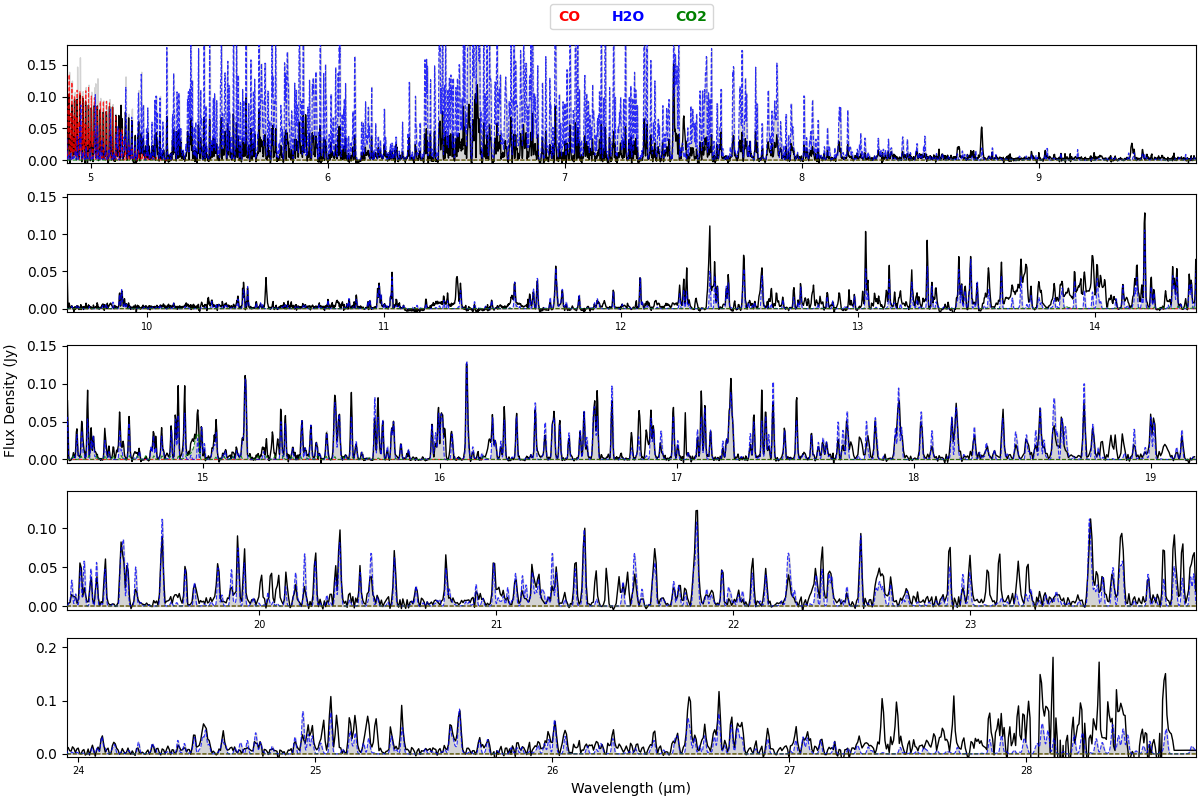

In [19]:
# --- Interactive FullSpectrumPlot with Output widget ---

fsp_output = widgets.Output()

# Number of panels
n_panels_slider = widgets.IntSlider(
    value=5, min=2, max=15, step=1,
    description='Panels:',
    continuous_update=False,
    style={'description_width': '80px'},
)

# Wavelength sub-range
fsp_range_slider = widgets.FloatRangeSlider(
    value=[float(wave_grid.min()), float(wave_grid.max())],
    min=float(wave_grid.min()),
    max=float(wave_grid.max()),
    step=0.5,
    description='λ range (μm):',
    continuous_update=False,
    style={'description_width': '100px'},
    layout=widgets.Layout(width='600px'),
)

def render_full_spectrum(change=None):
    """Rebuild the FullSpectrumPlot inside the Output widget."""
    xmin, xmax = fsp_range_slider.value

    fsp = FullSpectrumPlot(
        wave_data=wave_grid,
        flux_data=observed_flux,
        molecules=mol_dict,
        n_panels=n_panels_slider.value,
        xlim_range=(xmin, xmax),
    )
    fsp.generate_plot()

    with fsp_output:
        clear_output(wait=True)
        display(fsp.fig.canvas)

# Initial render
render_full_spectrum()

# Wire observers
n_panels_slider.observe(render_full_spectrum, names='value')
fsp_range_slider.observe(render_full_spectrum, names='value')

display(widgets.HBox([n_panels_slider, fsp_range_slider]))
display(fsp_output)

## 7. Side-by-Side Comparison — `interact` Shorthand

For quick exploration, `ipywidgets.interact` provides a one-liner approach. Here we compare two temperatures of the same molecule side-by-side using `interactive_output`.

In [20]:
# --- Quick interactive comparison using interactive_output ---

compare_output = widgets.Output()

compare_temp_slider = widgets.IntSlider(
    value=850, min=100, max=2000, step=50,
    description='Temperature (K):',
    continuous_update=False,
    style={'description_width': '130px'},
    layout=widgets.Layout(width='500px'),
)

compare_mol_dropdown = widgets.Dropdown(
    options=list(mol_dict.keys()),
    value="H2O",
    description='Molecule:',
    style={'description_width': '80px'},
)

compare_xmin = widgets.FloatText(value=14.0, description='λ min:', step=0.5,
                                  style={'description_width': '50px'},
                                  layout=widgets.Layout(width='150px'))
compare_xmax = widgets.FloatText(value=17.0, description='λ max:', step=0.5,
                                  style={'description_width': '50px'},
                                  layout=widgets.Layout(width='150px'))

def compare_temperatures(temp, mol_name, xmin, xmax):
    """Show two population diagrams: original vs. new temperature."""
    mol = mol_dict[mol_name]
    original_temp = mol.temp

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: line inspection at original temperature
    mol.temp = original_temp
    lip_orig = LineInspectionPlot(
        wave_data=wave_grid, flux_data=observed_flux,
        xmin=xmin, xmax=xmax, molecule=mol, ax=axes[0],
    )
    lip_orig.generate_plot()
    axes[0].set_title(f"{mol_name} — T = {original_temp:.0f} K (original)")

    # Right: line inspection at slider temperature
    mol.temp = float(temp)
    lip_new = LineInspectionPlot(
        wave_data=wave_grid, flux_data=observed_flux,
        xmin=xmin, xmax=xmax, molecule=mol, ax=axes[1],
    )
    lip_new.generate_plot()
    axes[1].set_title(f"{mol_name} — T = {temp} K (adjusted)")

    fig.tight_layout()
    plt.show()

    # Restore original temperature
    mol.temp = original_temp

out = widgets.interactive_output(
    compare_temperatures,
    {'temp': compare_temp_slider, 'mol_name': compare_mol_dropdown,
     'xmin': compare_xmin, 'xmax': compare_xmax},
)

controls = widgets.VBox([
    widgets.HBox([compare_mol_dropdown, compare_xmin, compare_xmax]),
    compare_temp_slider,
])
display(controls, out)

Output()

## 8. Bulk Parameter Explorer — Adjust All Molecules at Once

Use `MoleculeDict.bulk_update_parameters()` to change a shared parameter across all molecules simultaneously. Here a single slider controls the distance to the source, which scales the flux of every molecule.

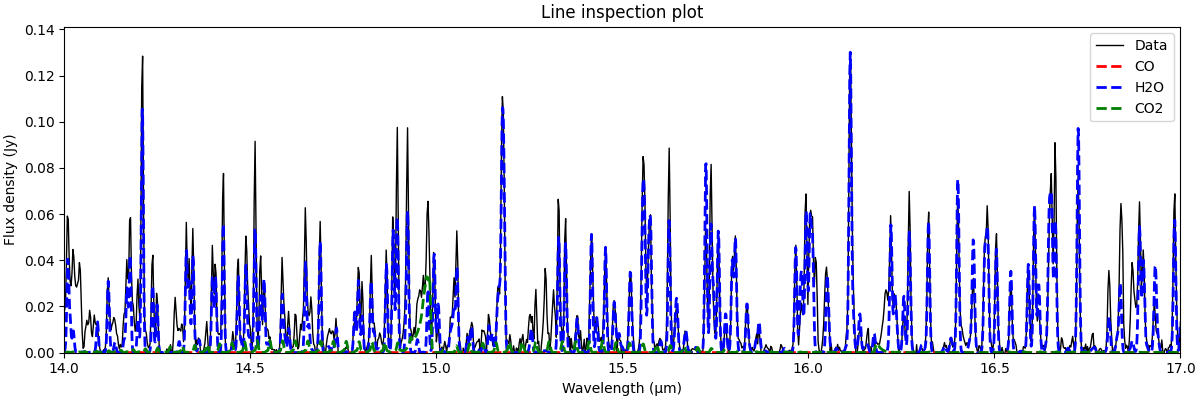

In [21]:
# --- Global distance slider affecting all molecules ---

bulk_lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=17.0,
    molecules=mol_dict,
    figsize=(12, 4),
)
bulk_lip.generate_plot()

distance_slider = widgets.IntSlider(
    value=int(mol_dict.global_distance),
    min=50, max=500, step=10,
    description='Distance (pc):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

fwhm_slider = widgets.IntSlider(
    value=130,
    min=10, max=500, step=10,
    description='FWHM (km/s):',
    continuous_update=False,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

bulk_status = widgets.HTML(value=f"<i>Distance: {mol_dict.global_distance} pc | FWHM: 130 km/s</i>")

def on_bulk_change(change):
    """Update global distance and FWHM for all molecules."""
    mol_dict.global_distance = float(distance_slider.value)
    mol_dict.bulk_update_parameters({'fwhm': float(fwhm_slider.value)})
    bulk_lip.generate_plot()
    bulk_lip.fig.canvas.draw_idle()
    bulk_status.value = (
        f"<i>Distance: {distance_slider.value} pc | "
        f"FWHM: {fwhm_slider.value} km/s</i>"
    )

distance_slider.observe(on_bulk_change, names='value')
fwhm_slider.observe(on_bulk_change, names='value')

display(widgets.VBox([distance_slider, fwhm_slider, bulk_status]))
bulk_lip.show()

## Quick Reference

### Widget ↔ Plot Patterns

| Widget type | Plot method | Use case |
|------------|-------------|----------|
| `FloatRangeSlider` | `lip.set_range(xmin, xmax)` | Pan/zoom the inspection window |
| `IntSlider` / `FloatSlider` | `mol.temp = value` then `plot.generate_plot()` | Adjust molecule parameters |
| `Dropdown` | `pdp.set_molecule(mol)` or `grid.set_active_molecule(mol)` | Switch active molecule |
| `Checkbox` | `mol.is_visible = bool` then `plot.generate_plot()` | Toggle molecule visibility |
| `interactive_output` | Rebuilds plot in an `Output` widget | Quick prototyping, side-by-side comparisons |

### Tips for Smooth Interactivity

- **Use `%matplotlib widget`** — the ipympl backend keeps figures interactive in the notebook. Without it, `fig.canvas.draw_idle()` has no effect.
- **Set `continuous_update=False`** on sliders to avoid triggering expensive recalculations on every pixel of slider movement. The callback fires only on mouse release.
- **Use `set_range()` / `set_molecule()` / `refresh()`** — these methods update plots in-place without recreating figures, which is much faster than building a new plot from scratch.
- **Use `Output` + `clear_output(wait=True)`** when the figure layout itself changes (e.g. number of panels in `FullSpectrumPlot`), since matplotlib cannot change subplot counts on an existing figure.
- **Guard against feedback loops** with a boolean flag (e.g. `_updating_sliders`) when multiple widgets are coordinated and one callback might trigger another.

### Import Path

```python
# Plotting classes
from iSLAT.Modules.Plotting import (
    LineInspectionPlot, PopulationDiagramPlot,
    FullSpectrumPlot, MainPlotGrid,
    BasePlot, DEFAULT_THEME,
)

# Data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output
```